In [1]:
#Run once per session
%load_ext autoreload
%autoreload 2
!pip install -q -U fastai

     |████████████████████████████████| 194kB 2.6MB/s 
     |████████████████████████████████| 51kB 3.5MB/s 


# ITL fast.ai model

In [2]:
from fastai.vision.all import *

In [3]:
VERSION=13
ITL_DS_NAME = f'itl_dataset_v{VERSION}.zip'
ITL_DS_URL =  f'http://students.mimuw.edu.pl/~mt406390/machine_learning/' + ITL_DS_NAME
!wget $ITL_DS_URL
!unzip -qq $ITL_DS_NAME -d data/
path = Path('data')

--2020-10-18 12:05:55--  http://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v13.zip
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v13.zip [following]
--2020-10-18 12:05:55--  https://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v13.zip
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13406847 (13M) [application/zip]
Saving to: ‘itl_dataset_v13.zip’

itl_dataset_v13.zip 100%[===================>]  12.79M  4.52MB/s    in 2.8s    

2020-10-18 12:06:00 (4.52 MB/s) - ‘itl_dataset_v13.zip’ saved [13406847/13406847]



In [4]:
path.ls()

(#9) [Path('data/annotations.json'),Path('data/operators.txt'),Path('data/depths.txt'),Path('data/output_bbox'),Path('data/job.json'),Path('data/output_black'),Path('data/output_color'),Path('data/output_proper'),Path('data/itl_labels.txt')]

In [5]:
with open(path / 'annotations.json') as f:
    annots = json.load(f)
print(len(annots))

annots = list(filter(lambda x: len(x['exprs']) > 0, annots))

800


In [6]:
images = list(x['name'] for x in annots if len(x['exprs']) > 0)
print(len(images))
images[0]

800


'eq0.png'

In [7]:
ops_cfg = {
  "leaf": {
    "latex": "{0}",
    "operands": 0,
    "inline": true
  },
  "add": {
    "latex": "{0}+{1}",
    "operands": 2,
    "inline": true
  },
  "times": {
    "latex": "{0} \\times {1}",
    "operands": 2,
    "inline": true
  },
  "star": {
    "latex": "{0} \\star {1}",
    "operands": 2,
    "inline": true
  },
  "div": {
    "latex": "{0} \\div {1}",
    "operands": 2,
    "inline": true
  },
  "otimes": {
    "latex": "{0} \\otimes {1}",
    "operands": 2,
    "inline": true
  },
  "sub": {
    "latex": "{0}-{1}",
    "operands": 2,
    "inline": true
  },
  "mul": {
    "latex": "{0} \\cdot {1}",
    "operands": 2,
    "inline": true
  },
  "frac": {
    "latex": "\\frac{{ {0} }}{{ {1} }}",
    "operands": 2
  },
  "sqrt": {
    "latex": "\\sqrt{{ {0} }}",
    "operands": 1
  },
  "int": {
    "latex": "\\int \\left( {0} \\right)",
    "operands": 1
  },
  "sum": {
    "latex": "\\sum \\left( {0} \\right)",
    "operands": 1
  },
  "pi": {
    "latex": "\\prod \\left( {0} \\right)",
    "operands": 1
  },
  "par": {
    "latex": "\\left( {0} \\right)",
    "operands": 1
  },
  "fpar": {
    "latex": "f\\left( {0} \\right)",
    "operands": 1
  },
  "ffpar": {
    "latex": "F\\left( {0} \\right)",
    "operands": 1
  },
  "gpar": {
    "latex": "G\\left( {0} \\right)",
    "operands": 1
  }
}

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [8]:
img2bbox = dict(zip(images, annots))

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input. For our `y`'s, we'll define some `getters`. The first of which will be `noop`, as we don't care about our initial image, and then we'll grab our label and bbox coordinates (we'll also define our `get_items`)

In [9]:
def bbox_to_fastai(box):
    x, y, dx, dy = box
    return [x, y, x + dx, y + dy]

getters = [
    lambda o: path/'output_proper'/o, lambda o: list(map(bbox_to_fastai, img2bbox[o]['exprs'])),
    lambda o: len(img2bbox[o]['exprs']) * [img2bbox[o]['op']]
]

For our transforms, we'll use some of the ones we defined earlier

In [10]:
item_tfms = []
batch_tfms = [Zoom(0.6, 1.5), Warp(0.25), Saturation(max_lighting=0.5),
              Brightness(), Rotate()]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [11]:
def get_train_imgs(noop):  return images

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [12]:
pascal = DataBlock(blocks=(ImageBlock(cls=PILImageBW), BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(0.3),
                 get_items=get_train_imgs, 
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [13]:
BS = 16
dls = pascal.dataloaders(path/'train', bs=BS)
dls.c = len(ops_cfg)

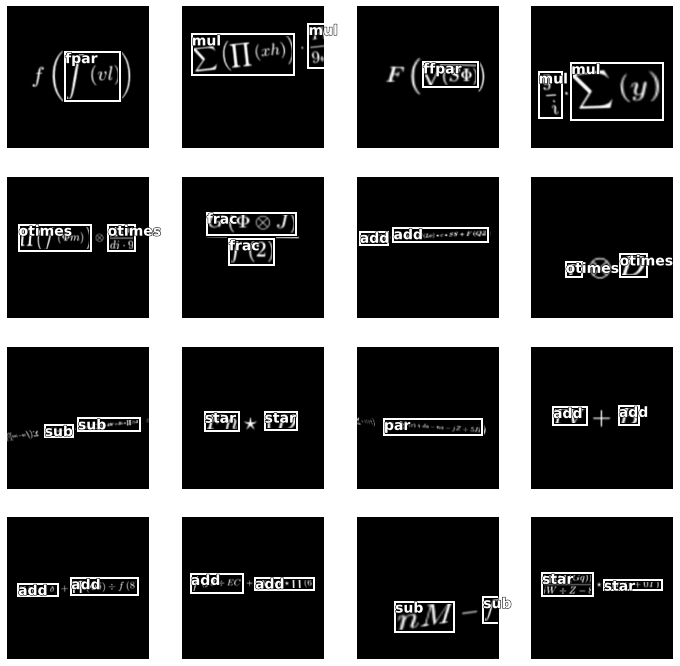

In [14]:
dls.show_batch(max_n=25)

# ITL model

In [15]:
POINTS_PER_BBOX = 4
N_BBOXES = 2
BBOXES = N_BBOXES * POINTS_PER_BBOX
CATS = dls.c
OUT = CATS + BBOXES

In [16]:
head = nn.Sequential(
    nn.Conv2d(512, 128, 3, 2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    # nn.BatchNorm2d(OUT),
    nn.Flatten()
)

bigger_shallow_head = nn.Sequential(
    nn.Conv2d(2048, 128, 3, 2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    # nn.BatchNorm2d(OUT),
    nn.Flatten()
)

bigger_head = nn.Sequential(
    nn.Conv2d(512, 256, 3, 1),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 128, 3, 1),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    # nn.BatchNorm2d(OUT),
    nn.Flatten()
)

fc = create_head(1024, OUT)

cfg = cnn_config(n_in=1, custom_head=head)

In [17]:
from torchvision.ops import box_iou

from pdb import set_trace

def encode_boxes(boxes_points):
    boxes_points = (boxes_points + 1) / 2
    x1, y1, x2, y2 = boxes_points[..., 0], boxes_points[..., 1], boxes_points[..., 2], boxes_points[..., 3]
    return torch.stack((x1, y1, torch.sqrt(x2 - x1), torch.sqrt(y2 - y1)), dim=-1)
    
def decode_boxes(boxes_lens):
    x, y, dx, dy = boxes_lens[..., 0], boxes_lens[..., 1], torch.square(boxes_lens[..., 2]), torch.square(boxes_lens[..., 3])
    boxes_points = torch.stack((x, y, x + dx, y + dy), dim=-1)
    return 2 * boxes_points - 1

class MseAndCrossEntropy(Module):
    def forward(self, pred, target_bboxes, target_cat):
        bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
        mask = (target_cat > 0)

        box_loss = F.mse_loss(bboxes_preds[mask], target_bboxes[mask])
        ce_loss = F.cross_entropy(pred[..., :CATS], target_cat[..., 0] - 1)
        return ce_loss + 50 * torch.sqrt(box_loss)

def ops_accuracy(pred, target_bboxes, target_cat):
    return accuracy(pred[..., :CATS], target_cat[..., 0] - 1)
    
def boxes_iou(pred, target_bboxes, target_cat):
    bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
    bboxes_decoded = decode_boxes(bboxes_preds)

    mask = (target_cat > 0)
    x, y = bboxes_decoded[mask], target_bboxes[mask]
    ious = torch.diagonal(box_iou(x, y))
    return ious.mean()


@log_args
class ITLLoss(BaseLoss):
    def __init__(self, *args, axis=-1, **kwargs):
        super().__init__(MseAndCrossEntropy, *args, axis=axis, **kwargs)

    def __call__(self, inp, targ, labels, **kwargs):
        targ_encoded = encode_boxes(targ)

        return self.func.__call__(inp, targ_encoded, labels)

    def decodes(self, x):
        categories, bboxes = x[...,:CATS], x[...,CATS:]
        bboxes = torch.sigmoid(bboxes)

        # Scaling back
        bboxes = decode_boxes(bboxes.view(-1, 2, 4))
        

        cats = (1 + categories.argmax(dim=-1)).unsqueeze(dim=-1)

        cats_stacked = torch.cat((cats, torch.zeros(cats.shape, dtype=torch.int64)), axis=-1)
        n = bboxes.shape[0]
        for i in range(n):
            current_cat = cats[i, 0]

            cat_lbl = dls.vocab[current_cat]

            if ops_cfg[cat_lbl]['operands'] == 2:
                cats_stacked[i, 1] = cats_stacked[i, 0]
            else:
                bboxes[i, 1] = 0

        return bboxes, TensorMultiCategory(cats_stacked)


In [18]:
learn = cnn_learner(dls, xse_resnext18, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
# learn.fit_one_cycle(20, 0.001905)
# learn.lr_find()

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import shutil 

drive = Path('drive')
weights_path = drive / 'My Drive' / 'models' / 'infer20.pth'
models_path = Path('models')
models_path.mkdir()
shutil.copy(weights_path, models_path)

'models/infer20.pth'

In [21]:
learn.load('infer20')

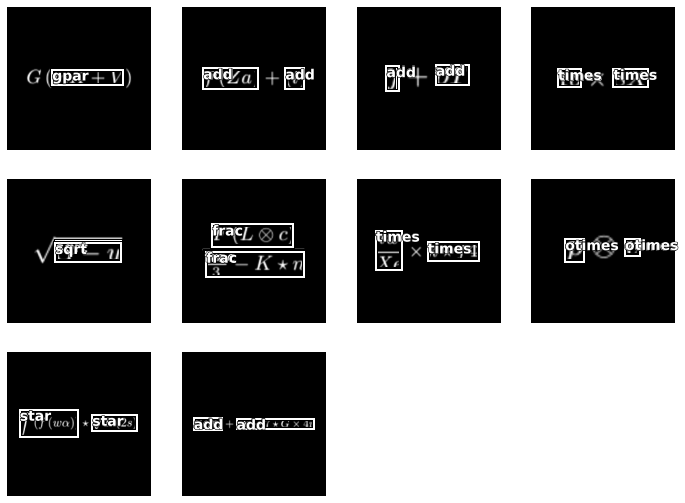

In [22]:
learn.show_results(max_n=10)

In [23]:
class Predictor():
    def __init__(self, learn: Learner):
        self.learn = learn

        self.labeler, self.point_scaler, self.to_tensor = learn.dls.valid.after_item
        self.scale_pixels = learn.dls.valid.after_batch[0]

        self.tfms = [self.labeler, self.point_scaler, self.to_tensor, self.scale_pixels]

        self.loss = ITLLoss()
    
    def _transform_img(self, img: PILImageBW) -> TensorImageBW:
        return self.scale_pixels(self.to_tensor(self.labeler(self.point_scaler(img))))[None]

    def _decode_after_fastai(self, boxes, cats):
        boxes = ((1 + boxes) / 2) * img.shape[1]
        
        # set_trace()
        x1, y1, x2, y2 = (boxes[0, :, i] for i in range(POINTS_PER_BBOX))
        boxes_coco = torch.stack((x1, y1, x2 - x1, y2 - y1), dim=-1)

        cat = self.learn.dls.vocab[cats[0, 0]]
        return boxes_coco, cat

    def _decode_preds(self, x):
        boxes, cats = self.loss.decodes(x)
        return self._decode_after_fastai(boxes, cats)


    def predict(self, img: PILImageBW):
        with torch.no_grad():
            preds = self.learn.model(to_device(self._transform_img(img), default_device()))

        return self._decode_preds(preds.cpu())

In [24]:
import abc
from dataclasses import dataclass
from typing import List

@dataclass
class Box:
    x: int
    y: int
    dx: int
    dy: int

@dataclass
class Operator:
    op_id: str

@dataclass
class Prediction:
    op: Operator
    bboxes: List[Box]

class Model(abc.ABC):
    @abc.abstractmethod
    def predict(self, input) -> Prediction:
        raise NotImplementedError

class ModelExample(Model):
    def predict(self, input) -> Prediction:
        return 'add', [Box(25, 25, 17, 17), Box(34, 34, 17, 17)]

class FastaiModelAdapter(Model):
    def __init__(self, predictor: Predictor):
        self._pred = predictor

    def _box_from_tensor(self, box_tensor):
        return Box(*map(lambda x: int(x.round().item()), box_tensor))

    def _make_pred(self, boxes_tensor, cat):
        boxes = [self._box_from_tensor(boxes_tensor[i])
            for i in range(boxes_tensor.shape[0])]

        return Prediction(
            op=Operator(cat),
            bboxes=boxes
        )

    def predict(self, input: PILImageBW) -> Prediction:
        return self._make_pred(*self._pred.predict(input))


In [25]:
pred = Predictor(learn)
fastai_model = FastaiModelAdapter(pred)

In [26]:
import cv2
from google.colab.patches import cv2_imshow

def resize_and_center_pred(full_img: PILImageBW, pred_bbox: Box) -> PILImageBW:
    def crop_img(image, bbox):
        proc = 0.03
        x_margin, y_margin = int(proc * bbox.dx), int(proc * bbox.dy) 
        return image[bbox.y:bbox.y + bbox.dy + y_margin, bbox.x:bbox.x + bbox.dx + x_margin]

    img_arr = np.array(full_img)
    img_cropped = crop_img(img_arr, pred_bbox)

    DIM, WHITE = 224, 255
    res = np.full((DIM, DIM), WHITE, dtype=np.uint8)

    y_shift = (DIM - img_cropped.shape[0]) // 2
    x_shift = (DIM - img_cropped.shape[1]) // 2
    
    res[y_shift:y_shift + img_cropped.shape[0], x_shift:x_shift + img_cropped.shape[1]] = img_cropped

    return PILImageBW.create(res)


In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class Inference:
    def __init__(self, model: Model):
        self.model = model
        self.MAX_DEPTH = 8

    def _show_pred(self, input: PILImageBW, pred: Prediction):
        print(f'pred: {pred.op.op_id}')
        for box in pred.bboxes:
            plt.gca().add_patch(Rectangle((box.x, box.y), box.dx, box.dy,linewidth=1,edgecolor='r',facecolor='none'))

        plt.imshow(input)
        plt.show()

    def __call__(self, input: PILImageBW, depth=0, debug=False) -> str:
        if depth > self.MAX_DEPTH:
            raise ValueError('stack overflow - your model too bad bro')

        pred = self.model.predict(input)

        if debug:
            self._show_pred(input, pred)
            

        operands = ops_cfg[pred.op.op_id]['operands']
        latex = ops_cfg[pred.op.op_id]['latex']

        if operands == 0:
            return latex
        
        inputs = [resize_and_center_pred(input, pred.bboxes[i]) for i in range(operands)]

        return latex.format(*(self(inp, depth + 1, debug) for inp in inputs))

In [28]:
infer = Inference(fastai_model)

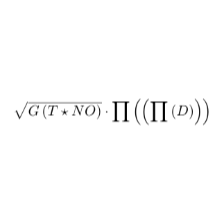

In [35]:
def img_from_path(path: Path) -> PILImageBW:
    return PILImageBW.create(path)

img = img_from_path(getters[0](images[642]))
img

pred: mul


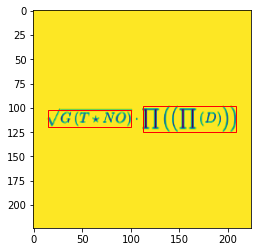

pred: sqrt


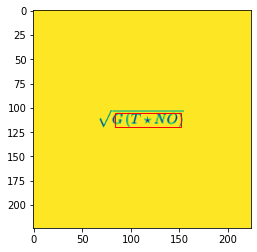

pred: gpar


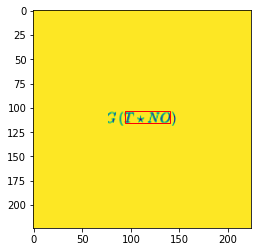

pred: star


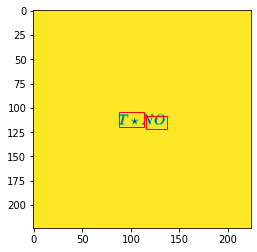

pred: leaf


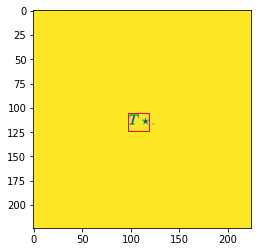

pred: leaf


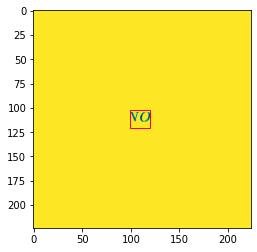

pred: pi


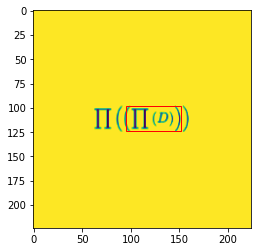

pred: par


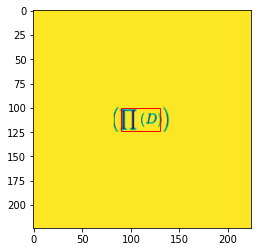

pred: pi


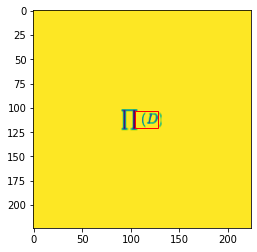

pred: leaf


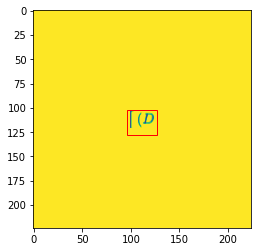

'\\sqrt{ G\\left( {0} \\star {0} \\right) } \\cdot \\prod \\left( \\left( \\prod \\left( {0} \\right) \\right) \\right)'

In [36]:
infer(img, debug=True)